<a href="https://colab.research.google.com/github/chechelan/0-chechelan/blob/main/bk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/lg5.zip -d celeba_gan

Archive:  /content/gdrive/MyDrive/lg5.zip
replace celeba_gan/lg4/i10.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: celeba_gan/lg4/i10.png  
 extracting: celeba_gan/lg4/i111.png  
 extracting: celeba_gan/lg4/i112.png  
 extracting: celeba_gan/lg4/i113.png  
 extracting: celeba_gan/lg4/i114.png  
 extracting: celeba_gan/lg4/i115.png  
 extracting: celeba_gan/lg4/i116.png  
 extracting: celeba_gan/lg4/i118.png  
 extracting: celeba_gan/lg4/i123.png  
 extracting: celeba_gan/lg4/i124.png  
 extracting: celeba_gan/lg4/i126.png  
 extracting: celeba_gan/lg4/i127.png  
 extracting: celeba_gan/lg4/i129.png  
 extracting: celeba_gan/lg4/i13.png  
 extracting: celeba_gan/lg4/i131.png  
 extracting: celeba_gan/lg4/i133.png  
 extracting: celeba_gan/lg4/i135.png  
 extracting: celeba_gan/lg4/i14.png  
 extracting: celeba_gan/lg4/i142.png  
 extracting: celeba_gan/lg4/i143.png  
 extracting: celeba_gan/lg4/i144.png  
 extracting: celeba_gan/lg4/i145.png  
 extracting: celeba_gan/lg4/i14

In [ ]:
from tensorflow import keras

In [ ]:
#get image 
dataset = keras.utils.image_dataset_from_directory("celeba_gan", 
                                                   label_mode=None,
                                                   image_size=(64,64),
                                                   batch_size=32,
                                                   smart_resize=True
                                                   )

Found 2920 files belonging to 1 classes.


In [ ]:
dataset = dataset.map(lambda x:x/255)

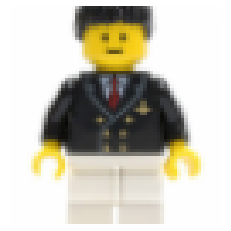

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
  plt.axis('off')
  plt.imshow((x.numpy()*255).astype('int32')[0])
  break

The discriminator 

In [ ]:
from tensorflow.keras import layers

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64,64,3)),
        layers.Conv2D(64,kernel_size=4,strides=2,padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128,kernel_size=4,strides=2,padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128,kernel_size=4,strides=2,padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1,activation = 'sigmoid'),
    ],
    name = 'discriminator',
)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

generator

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8*8*128),
        layers.Reshape((8,8,128)),
        layers.Conv2DTranspose(128,kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256,kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512,kernel_size=4, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2), 
        layers.Conv2D(3, kernel_size=5, padding='same',activation='sigmoid'),            
    ],
    name='generator'
)

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

the GAN MODEL

In [ ]:
import tensorflow as tf


In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}


a callback

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

In [ ]:
epochs =100

gan = GAN( discriminator=discriminator, generator=generator, 
          latent_dim= latent_dim)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset,epochs=epochs,
    callbacks=[GANMonitor(num_img=10,latent_dim=latent_dim)]
)

Epoch 1/100
92/92 [==============================] - 42s 294ms/step - d_loss: 0.3819 - g_loss: 0.9773
Epoch 2/100
92/92 [==============================] - 27s 295ms/step - d_loss: 0.4871 - g_loss: 2.2336
Epoch 3/100
92/92 [==============================] - 29s 315ms/step - d_loss: 0.4051 - g_loss: 1.6205
Epoch 4/100
92/92 [==============================] - 28s 305ms/step - d_loss: 0.3438 - g_loss: 2.5894
Epoch 5/100
92/92 [==============================] - 29s 311ms/step - d_loss: 0.2453 - g_loss: 4.0647
Epoch 6/100
92/92 [==============================] - 29s 310ms/step - d_loss: 0.2988 - g_loss: 2.1928
Epoch 7/100
92/92 [==============================] - 29s 309ms/step - d_loss: 0.4094 - g_loss: 2.0536
Epoch 8/100
92/92 [==============================] - 29s 312ms/step - d_loss: 0.6019 - g_loss: 1.0583
Epoch 9/100
92/92 [==============================] - 28s 306ms/step - d_loss: 0.5069 - g_loss: 1.1904
Epoch 10/100
92/92 [==============================] - 29s 319ms/step - d_loss: 0.5